In [1]:
import pandas as pd

df = pd.read_csv('2019.1 - Encuesta de remuneración salarial - Argentina.csv', skiprows=3)
df

,Me identifico,Tengo,Dónde estás trabajando,Años de experiencia,Años en la empresa actual,Años en el puesto actual,¿Gente a cargo?,Nivel de estudios alcanzado,Estado,Carrera,...,Orientación sexual,¿Tenés algún tipo de discapacidad?,¿Sentís que esto te dificultó el conseguir trabajo?,¿A qué eventos de tecnología asististe en el último año?,Cantidad de empleados,Actividad principal,¿La recomendás como un buen lugar para trabajar?,¿Cómo calificás las políticas de diversidad e inclusión?,¿A cuántos kilómetros de tu casa queda la oficina?,Beneficios extra
0,Hombre,22,Catamarca,2.0,1.0,1.0,0,Universitario,En curso,ING informática,...,Heterosexual,NaN,NaN,NaN,1001-2000,Producto basado en Software,8,9,2.0,Capacitaciones y/o cursos
1,Hombre,23,Catamarca,2.0,1.0,1.0,0,Secundario,Completado,Ing informática,...,Heterosexual,NaN,NaN,Charlas online,51-100,Producto basado en Software,8,10,2.0,"Capacitaciones y/o cursos, Licencia de paterni..."
2,Mujer,35,Chaco,8.0,7.0,2.0,2,Posgrado,En curso,MTI,...,dgsdg,NaN,No,varios,201-500,Otras industrias,4,4,0.2,"Capacitaciones y/o cursos, Licencia de paterni..."
3,Hombre,41,Chaco,20.0,2.0,10.0,0,Universitario,Completado,Lic en sistemas,...,Heterosexual,NaN,NaN,Ninguno,1-10,Servicios / Consultoría de Software / Digital,5,1,-1.0,"Horarios flexibles, Vacaciones flexibles (adic..."
4,Hombre,35,Chaco,5.0,3.0,2.0,0,Universitario,Completado,Analisis en Sistemas,...,Heterosexual,NaN,No,NaN,501-1000,Producto basado en Software,8,8,1.0,"Capacitaciones y/o cursos, Clases de idiomas, ..."
5,Hombre,38,Chaco,16.0,16.0,16.0,0,Terciario,Incompleto,Analista de Sistemas,...,Heterosexual,NaN,No,Ninguno,201-500,Otras industrias,6,4,2.0,Ninguna de las anteriores
6,Hombre,30,Chaco,9.0,5.0,5.0,3,Terciario,Completado,T S P,...,Heterosexual,NaN,No,NaN,201-500,Otras industrias,6,10,2.0,"Abono de celular y/o Internet, Comidas pagas/s..."
7,Hombre,32,Chaco,10.0,2.0,2.0,0,Universitario,Incompleto,Ing. en Sistemas,...,Heterosexual,NaN,NaN,Ninguno :(,1001-2000,Otras industrias,5,5,5.0,Ninguna de las anteriores
8,Hombre,28,Chaco,7.0,3.0,1.0,2,Universitario,Incompleto,Ingeniería en Sistemas,...,Heterosexual,NaN,No,NaN,51-100,Servicios / Consultoría de Software / Digital,10,5,-1.0,"Horarios flexibles, Vacaciones flexibles (adic..."
9,Hombre,29,Chaco,0.0,0.0,0.0,0,Universitario,En curso,Ingenieria en Sistemas,...,Heterosexual,NaN,No,NaN,501-1000,Producto basado en Software,5,5,3.0,Capacitaciones y/o cursos


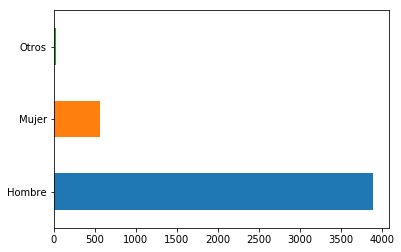

In [2]:
%matplotlib inline
df['Me identifico'].value_counts().plot.barh();

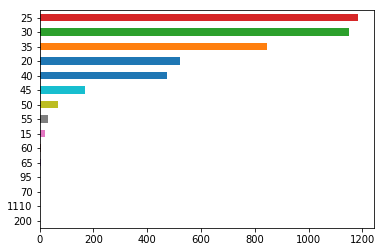

In [3]:
df['Tengo'].apply(lambda x: 5 * (x // 5)).value_counts(sort=True, ascending=True).plot.barh();

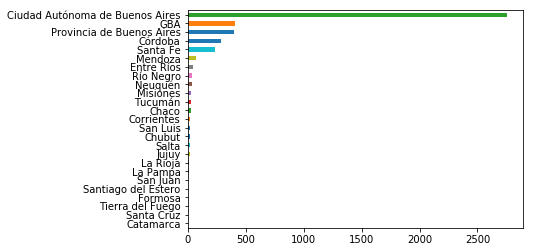

In [4]:
df['Dónde estás trabajando'].value_counts(sort=True, ascending=True).plot.barh();

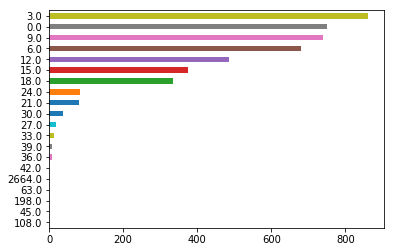

In [5]:
df['Años de experiencia'].apply(lambda x: 3 * (x // 3)).value_counts(sort=True, ascending=True).tail(20).plot.barh();

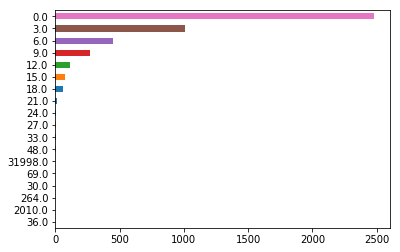

In [6]:
df['Años en la empresa actual'].apply(lambda x: 3 * (x // 3)).value_counts(sort=True, ascending=True).tail(20).plot.barh();

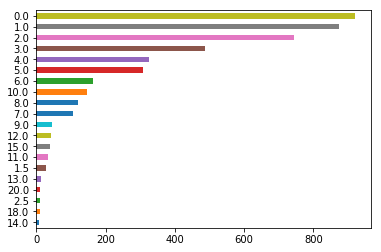

In [7]:
df['Años en el puesto actual'].value_counts(sort=True, ascending=True).tail(20).plot.barh();

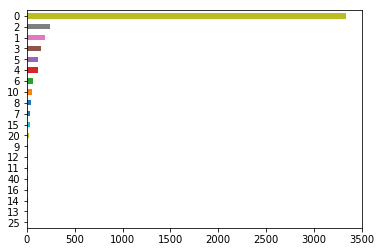

In [8]:
df['¿Gente a cargo?'].value_counts(sort=True, ascending=True).tail(20).plot.barh();

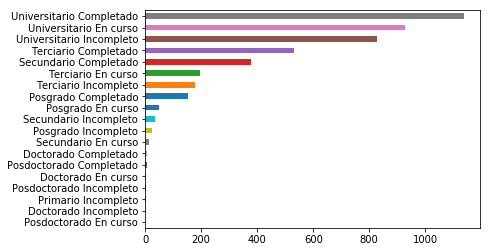

In [9]:
df.apply(lambda row: '{} {}'.format(row['Nivel de estudios alcanzado'], row['Estado']), axis=1).value_counts(sort=True, ascending=True).tail(20).plot.barh();

In [10]:
import re #ahre
regex_replace_map = {
    '^(Ing\.?|In?geni?[ea]r([íi]a|a|o))( en| de|) (.*)$': 'Ingeniería en \\4',
    '^(Ing\.?|Ingeni?er([íi]a|a|o|))$': 'Ingeniería',
    '^[LI]ic(enciatura|enciad[ao]|\.|)( en| de|) (.*)$': 'Licenciatura en \\3',
    '^Analistas?( de| en) (.*)$': 'Analista de \\2',
    '^(Tec\.? |T[eé]cnic(atura|a|o))(.*)$': 'Tecnicatura\\3',
    '^(Dr\.?|Doctor(ado|a|))( en| de|) (.*)$': 'Doctorado en \\4',
    '^Contador(a|).*$': 'Contador Público',
    '^Programador(a|).*$': 'Programación',
    '^(Abocac[íi]a|abogad[ao])$': 'Abogacía',
    '^(.*)ing[\. ](.+)$': '\\1Ingeniería \\2',
    '^(.*)lic[\. ](.+)$': '\\1Licenciatura \\2',
    '^(.*)(mg|mag|magister|maestr[íi]a)[\. ](.+)$': '\\1Maestría \\3',
    '^(.*)informaci[óo]n(.*)$': '\\1Información\\2',
    '^(.*)computaci[óo]n(.*)$': '\\1Computación\\2',
    '^(.*)inform[áàa]tica(.*)$': '\\1Informática\\2',
    '^(.*)programaci[óo]n(.*)$': '\\1Programación\\2',
    '^(.*)licenciatura(.*)$': '\\1Licenciatura\\2',
    '^(.*)electr[óo]nica(.*)$': '\\1Electrónica\\2',
    '^(.*)el[ée]ctrica(.*)$': '\\1Eléctrica\\2',
    '^(.*)tecnolog[íi]a(.*)$': '\\1Tecnología\\2',
    '^(.*)administraci[óo]n(.*)$': '\\1Administración\\2',
    '^(.*)sistem[as]s(.*)$': '\\1Sistemas\\2',
    '^(.*)ingeniero[as](.*)$': '\\1Ingeniería\\2',
    '^(.*)analista(.*)$': '\\1Analista\\2',
    '^(.*)(adm|admin)[ \.](.*)$': '\\1Administración \\2',
    '^(.*)inform[aá]ticos(.*)$': '\\1Informáticos\\2',
    '^(.*)liciencia(.*)$': '\\1licencia\\2', # OMG!
    '^(.*)ciencias?(.*)$': '\\1Ciencias\\2',
    '^(.*)cs\.?(.+)$': '\\1Ciencias\\2',
    '^(.*)an[áàa]lisis(.*)$': '\\1Análisis\\2',
    '^(.*)gesti[óo]n(.*)$': '\\1Gestión\\2',
    '^(.*)ux(.*)$': '\\1UX\\2',
    '^(.*)superior(.*)$': '\\1Superior\\2',
    '^(.*)rrhh(.*)$': '\\1Recursos Humanos\\2',
    '^(.*)empresa(.*)$': '\\1Empresa\\2',
    '^(.*)im[áa]gen(.*)$': '\\1Imágen\\2',
    '^(.*)sonido(.*)$': '\\1Sonido\\2',
    '^(.*)diseño(.*)$': '\\1Diseño\\2',
    '^(.*)electr[óo]nico(.*)$': '\\1Electrónico\\2',
    '^(.*)seguridad(.*)$': '\\1Seguridad\\2',
    '^(.*)higiene(.*)$': '\\1Higiene\\2',
    '^(.*)mec[áa]nica(.*)$': '\\1Mecánica\\2',
    '^(.*)telecomunicaciones(.*)$': '\\1Telecomunicaciones\\2',
    '^(.*)teleinform[áa]tica(.*)$': '\\1Teleinformática\\2',
    '^(.*)industrial(.*)$': '\\1Industrial\\2',
    '^(.*)universitari(.*)$': '\\1Universitari\\2',
    '^(.*)gr[áa]fico(.*)$': '\\1Gráfico\\2',
    '^(.*)desarrollo(.*)$': '\\1Desarrollo\\2',
    '^(.*)software(.*)$': '\\1Software\\2',
    '^(.*)social(.*)$': '\\1Social\\2',
    '^traductor(a|ado|)( P[úu]blico| de .+)?$': 'Traductorado Público',
    '^(.*)p[úu]blico(.*)$': '\\1Público\\2',
    '^(.*)trabajo(.*)$': '\\1Trabajo\\2',
    '^(.*)sitio(.*)$': '\\1Sitio\\2',
    '^(.*)filosof[íi]a(.*)$': '\\1Filosofía\\2',
    '^(.*)redes(.*)$': '\\1Redes\\2',
    '^(.*)psicolog[íi]a(.*)$': '\\1Psicología\\2',
    '^(.*)programador(.*)$': '\\1Programador\\2',
    '^(.*)biom[ée]dic(.*)$': '\\1Biomédic\\2',
    '^(.*)web(.*)$': '\\1Web\\2',
    '^(.*)arte(.*)$': '\\1Arte\\2',
    '^(.*)dela(.*)$': '\\1de la\\2',
    '^(.*)en en(.*)$': '\\1 en \\2',
    '^(.*) de (.*)$': '\\1 de \\2',
    '^(.*) en (.*)$': '\\1 en \\2',
    '^(.*)comunica(dor|dora|ci[óo]n)(.*)$': '\\1Comunicación\\3',
    '^(.*)telecomunicaci[óo]n(es)?(.*)$': '\\1Telecomunicaciones\\3',
    '^(.*)visual(.*)$': '\\1Visual\\2',
    '^fot[óo]graf(a|o|ia|ía)$': 'Fotografía',
    '^(.*)  (.*)$': '\\1 \\2',
    '^(TSP|T S P|T\.S\.P\.?)$': 'Tecnicatura Superior en Programación',
    '^(TSU|T S U|T\.S\.U\.?)(.*)$': 'Tecnicatura Superior Universitaria\\2',
    '^(ISI|I S I|I\.S\.I\.?)$': 'Ingeniería en Sistemas de Información',
    '^(.*)T\.? sup[\.](.*)$': '\\1Tecnicatura Superior\\2',
    '^(Tecnicatura|Ingeniería)( en | )(Industrial|Civil|Electrónic[ao]|Biom[ée]dica|Eléctrica|Mecánica)$': '\\1 \\3',
    '^(Tecnicatura|Ingeniería) Electrónic[ao]$': '\\1 Electrónica',
    '^(Ingeniería|Licenciatura) en Sistemas?(| de Información| en Información| de la Información| Inform[áa]ticos)$': '\\1 en Sistemas de Información',
    '^(.*)Superior Programación(.*)$': '\\1Superior en Programación\\2',
    '^(.*)Tecnicatura Universitario(.*)$': '\\1Tecnicatura Universitaria\\2',
    '^(.*)Tecnicaturaen(.*)$': '\\1Tecnicatura en\\2',
    '^(.*)TecnicaturaSuperior(.*)$': '\\1Tecnicatura Superior\\2',
    '^(.*)TecnicaturaProgramación(.*)$': '\\1Tecnicatura en Programación\\2',
    '^Tecnicatura Programador(.*)$': 'Tecnicatura en Programación',
    '^(LCC|Ciencias Computación|Licenciatura en Computación|Ciencias de la Computación)$': 'Licenciatura en Ciencias de la Computación',
    '^(An[áa]lisis de Sistemas?|Analista( de|) Sistemas?).*$': 'Analista de Sistemas',
    '^(Diseñ(o|ador|adora) Multimedial?|Multimedia)$': 'Diseño Multimedial',
    '^(.*)Universitario en Sistemas(.*)$': '\\1Universitario de Sistemas\\2',
    '^(.*)\.$': '\\1',
}
for regex, pattern in regex_replace_map.items():
    compiled_regex = re.compile(regex, re.I)
    df['Carrera'] = df['Carrera'].str.strip().str.replace(compiled_regex, pattern)

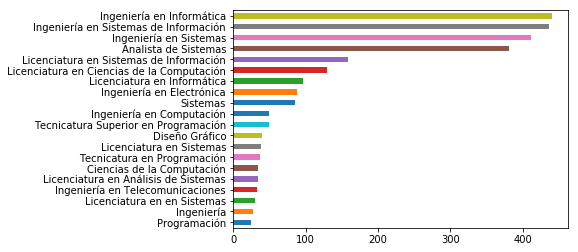

In [11]:
df['Carrera'].value_counts(sort=True, ascending=True).tail(20).plot.barh();

In [12]:
regex_replace_map = {
    '(UTN|UTN .*|UTN ?F.*|Universidad Tec?nol[óo]gica Nacional( F.*)?)$': 'UTN',
    '(UBA|FIUBA|FCE-?UBA|Universidad de Buenos Aires|Buenos Aires)$': 'UBA',
    '(UNLP|Universidad Nacional de La Plata)$': 'UNLP',
    '(UNLaM|Universidad( Nacional|) de la Matanza|la matanza)$': 'UNLaM',
    '(UNS|Universidad Nacional del Sur)$': 'UNS',
    '(UNICEN|Universidad Nacional del Centro( de la (Provincia|Pcia\.?) de Buenos Aires)?)$': 'UNICEN',
    '(UNC|Universidad Nacional de C[óo]rdoba)$': 'UNC',
    '(UNRC|Universidad Nacional de R[ií]o Cuarto)$': 'UNRC',
    '(UNQ|Universidad Nacional de Quilmes|Unqui)$': 'UNQ',
    '(UADE|Universidad Argentina de la Empresa)$': 'UADE',
    '(UB|Universidad de Belgrano)$': 'UB',
    '(UK|(Universidad )?Kennedy)$': 'UK',
    '(UCES|Universidad de Ciencias Empresariales y Sociales)$': 'UCES',
    '(UM|Universidad de Mor[óo]n|Mor[óo]n)$': 'UM',
    '(UP|Universidad de Palermo|Palermo)$': 'UP',
    '(CAECE|UCAECE|Universidad CAECE)$': 'CAECE',
    '(ORT|ORT Argentina)$': 'ORT',
    '(UAI|(Universidad )?Abierta Interamericana)$': 'UAI',
    '(UBP|(Universidad )?Blas Pascal)$': 'UBP',
    '(Universidad )?(Maim[óo]nides)$': 'Maimónides',
    '(UNLA|.*Lan[úu]s)$': 'UNLA',
    '(UNL|(Universidad )?Nacional del Litoral)$': 'UNL',
    '(UNLu|Universidad Nacional de Luj[áa]n)$': 'UNLu',
    '((Escuela .?)?(Multimedial? )?)?Da ?Vinci$': 'DaVinci',
    '(Universidad )?(Siglo 21|Siglo XXI)$': 'Siglo 21',
    '(UA|(Universidad )?Austral)$': 'UNL',
    '(UA|(Universidad )?Austral)$': 'UNL',
    '(Istea)$': 'ISTEA',
    '(UAP|Universidad Adventista del Plata)': 'UAP',
    '(UNJu|Universidad Nacional de Jujuy)': 'UNJu',
    '(UNCUYO|Universidad Nacional de Cuyo)': 'UNCUYO',
    '(ISSD|Instituto Superior Santo Domingo)': 'ISSD',
    '(UNSAM|Universidad Nacional de San Mart[ií]n)': 'UNSAM',
    '(UNLAR|Universidad Nacional de La Rioja)': 'UNLaR',
    '(UNCOMA|Universidad Nacional del Comahue)': 'UNCOMA',
    '(UDA|Universidad del Aconcagua)': 'UDA',
    '(IUA|Instituto Universitario Aeronautico)': 'IUA',
    '(-)$': 'DELETEME',
}
for regex, pattern in regex_replace_map.items():
    compiled_regex = re.compile(regex, re.I)
    df['Universidad'] = df['Universidad'].str.strip().str.replace(compiled_regex, pattern)

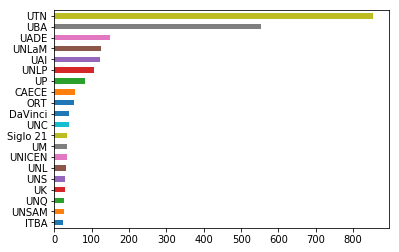

In [13]:
df['Universidad'].value_counts(sort=True, ascending=True).tail(20).plot.barh();

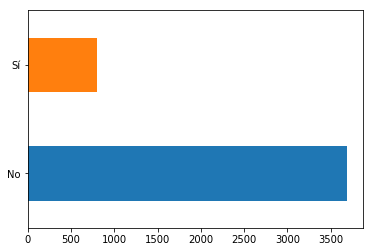

In [14]:
df['¿Contribuís a proyectos open source?'].value_counts().plot.barh();

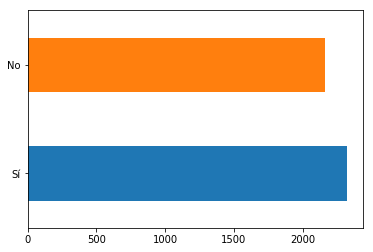

In [15]:
df['¿Programás como hobbie?'].value_counts().plot.barh();

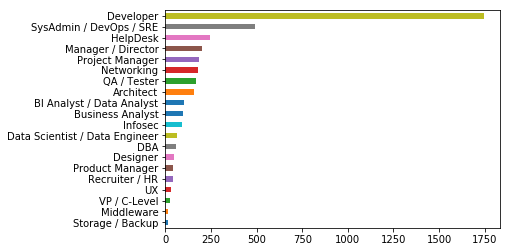

In [16]:
df['Trabajo de'].value_counts(sort=True, ascending=True).tail(20).plot.barh();

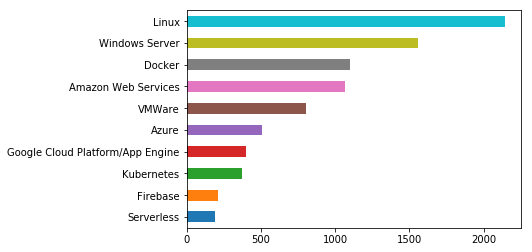

In [17]:
tech_count = {}
for x in df['Plataformas'].dropna():
    for key in x.split(','):
        key = key.strip()
        tech_count[key] = tech_count.get(key, 0) + 1
pd.Series(tech_count).sort_values(ascending=True).tail(10).plot.barh();

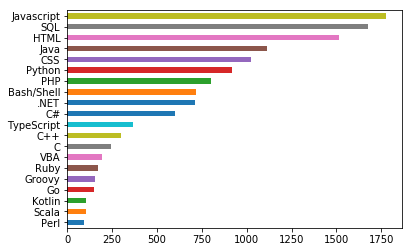

In [18]:
languages_count = {}
for x in df['Lenguajes de programación'].dropna():
    for key in x.split(','):
        key = key.strip()
        languages_count[key] = languages_count.get(key, 0) + 1
pd.Series(languages_count).sort_values(ascending=True).tail(20).plot.barh();

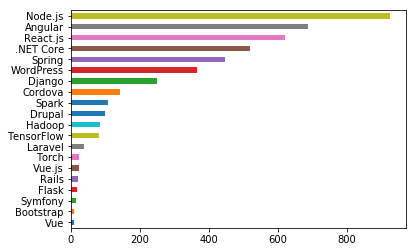

In [19]:
fw_count = {}
for x in df['Frameworks, herramientas y librerías'].dropna():
    for key in x.split(','):
        key = key.strip()
        fw_count[key] = fw_count.get(key, 0) + 1
pd.Series(fw_count).sort_values(ascending=True).tail(20).plot.barh();

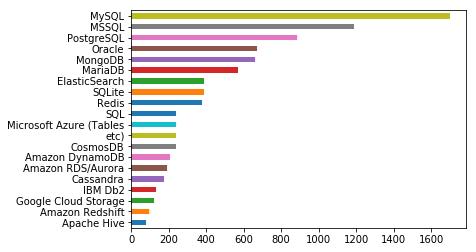

In [20]:
db_count = {}
for x in df['Bases de datos'].dropna():
    for key in x.split(','):
        key = key.strip()
        db_count[key] = db_count.get(key, 0) + 1
pd.Series(db_count).sort_values(ascending=True).tail(20).plot.barh();

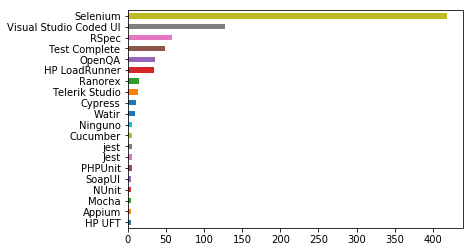

In [21]:
qat_count = {}
for x in df['QA / Testing'].dropna():
    for key in x.split(','):
        key = key.strip()
        qat_count[key] = qat_count.get(key, 0) + 1
pd.Series(qat_count).sort_values(ascending=True).tail(20).plot.barh();

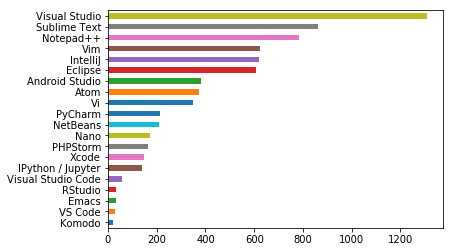

In [22]:
ide_count = {}
for x in df['IDEs'].dropna():
    for key in x.split(','):
        key = key.strip()
        ide_count[key] = ide_count.get(key, 0) + 1
pd.Series(ide_count).sort_values(ascending=True).tail(20).plot.barh();

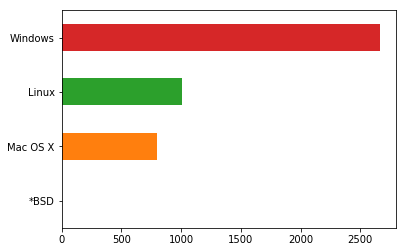

In [23]:
df['¿Qué SO usás en tu laptop/PC para trabajar?'].value_counts(sort=True, ascending=True).tail(20).plot.barh();

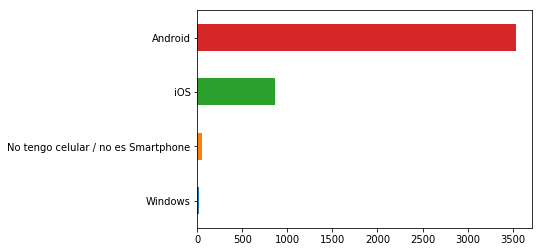

In [24]:
df['¿Y en tu celular?'].value_counts(sort=True, ascending=True).tail(20).plot.barh();

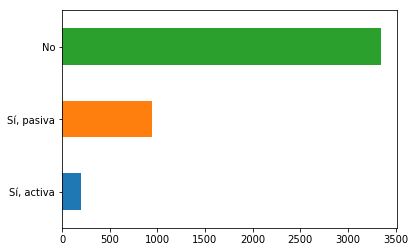

In [25]:
df['¿Tenés guardias?'].value_counts(sort=True, ascending=True).tail(20).plot.barh();

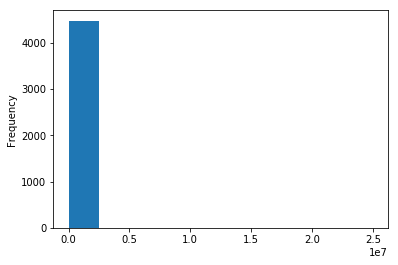

In [26]:
df['Salario mensual BRUTO (en tu moneda local)'].plot.hist();

In [27]:
df['Salario mensual BRUTO (en tu moneda local)'].sort_values().head()

1906    1.0
2124    1.0
43      1.0
2235    1.0
3916    1.0
Name: Salario mensual BRUTO (en tu moneda local), dtype: float64

In [28]:
df['Salario mensual BRUTO (en tu moneda local)'].sort_values().tail()

3274      931415.92
4029     1500000.00
2349     3572000.00
3169     5138262.00
3919    25000000.00
Name: Salario mensual BRUTO (en tu moneda local), dtype: float64

In [29]:
(df['Salario mensual BRUTO (en tu moneda local)'] < 10000).sum()

151

In [30]:
df[(df['Salario mensual BRUTO (en tu moneda local)'] < 12000) & (df['Salario mensual BRUTO (en tu moneda local)'] > 10000)]

,Me identifico,Tengo,Dónde estás trabajando,Años de experiencia,Años en la empresa actual,Años en el puesto actual,¿Gente a cargo?,Nivel de estudios alcanzado,Estado,Carrera,...,Orientación sexual,¿Tenés algún tipo de discapacidad?,¿Sentís que esto te dificultó el conseguir trabajo?,¿A qué eventos de tecnología asististe en el último año?,Cantidad de empleados,Actividad principal,¿La recomendás como un buen lugar para trabajar?,¿Cómo calificás las políticas de diversidad e inclusión?,¿A cuántos kilómetros de tu casa queda la oficina?,Beneficios extra
662,Mujer,20,Ciudad Autónoma de Buenos Aires,0.0,0.0,0.0,0,Universitario,En curso,Ingeniería en Sistemas de Información,...,Heterosexual,NaN,NaN,NaN,201-500,Servicios / Consultoría de Software / Digital,7,9,5.0,"Capacitaciones y/o cursos, Descuentos varios (..."
1075,Mujer,25,Ciudad Autónoma de Buenos Aires,0.0,0.0,0.0,0,Universitario,En curso,Ingeniería en Sistemas de Información,...,Heterosexual,NaN,NaN,Digital Summit 2018,1001-2000,Servicios / Consultoría de Software / Digital,8,9,9.0,"Capacitaciones y/o cursos, Descuentos varios (..."
1261,Mujer,21,Ciudad Autónoma de Buenos Aires,1.0,1.0,1.0,0,Universitario,En curso,Diseño Gráfico,...,Bisexual o queer,NaN,NaN,NaN,1-10,Producto basado en Software,8,1,8.0,"Horarios flexibles, Vacaciones flexibles (adic..."
1976,Hombre,26,Ciudad Autónoma de Buenos Aires,0.0,0.0,0.0,0,Terciario,Completado,Diseño Multimedial,...,Pansexual,NaN,No,NaN,1-10,Servicios / Consultoría de Software / Digital,5,5,5.0,Comidas pagas/subvencionadas
2393,Hombre,71,Ciudad Autónoma de Buenos Aires,20.0,3.0,20.0,0,Universitario,Incompleto,Ingeniería,...,Heterosexual,NaN,No,0,11-50,Otras industrias,2,2,5.0,Ninguna de las anteriores
2798,Hombre,22,Córdoba,1.0,1.0,1.0,0,Universitario,En curso,Ingeniería en Software,...,Heterosexual,NaN,NaN,PyData Córdoba,201-500,Otras industrias,6,7,9.6,"Capacitaciones y/o cursos, Descuentos varios (..."
2804,Hombre,20,Córdoba,1.0,1.0,1.0,0,Universitario,En curso,Ingeniería en Sistemas de Información,...,Heterosexual,NaN,NaN,Facebook Developers Circle CBA,11-50,Otras industrias,7,8,8.0,"Capacitaciones y/o cursos, Playroom"
2949,Hombre,38,Córdoba,5.0,5.0,5.0,0,Universitario,En curso,Ingeniería en Telecomunicaciones,...,Heterosexual,NaN,NaN,NaN,51-100,Otras industrias,8,9,4.0,"Capacitaciones y/o cursos, Horarios flexibles"
3124,Hombre,32,Entre Ríos,5.0,4.0,4.0,2,Universitario,En curso,Licenciatura en Sistemas de Información,...,Heterosexual,NaN,No,Conferencias de Seguridad Informática,1-10,Producto basado en Software,6,6,12.0,Ninguna de las anteriores
3890,Hombre,28,Provincia de Buenos Aires,1.0,1.0,1.0,0,Universitario,Completado,Tecnicatura Superior en Programación,...,Heterosexual,NaN,NaN,NaN,1-10,Producto basado en Software,10,10,3.0,"Horarios flexibles, Vacaciones flexibles (adic..."


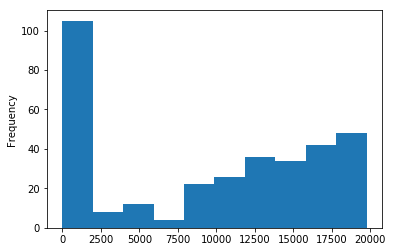

In [31]:
df[(df['Salario mensual BRUTO (en tu moneda local)'] < 20000)]['Salario mensual BRUTO (en tu moneda local)'].plot.hist();

In [32]:
df['Salario mensual BRUTO (en tu moneda local)'].sort_values().tail(20)

59        330000.00
58        332200.00
409       340000.00
3694      356783.00
299       370000.00
500       370000.00
3192      370000.00
591       440000.00
2109      450000.00
3489      550000.00
4129      576000.00
746       600000.00
1274      600000.00
2387      630000.00
2489      720000.00
3274      931415.92
4029     1500000.00
2349     3572000.00
3169     5138262.00
3919    25000000.00
Name: Salario mensual BRUTO (en tu moneda local), dtype: float64

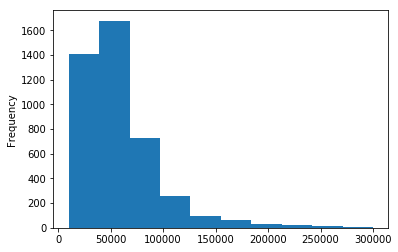

In [33]:
df[(df['Salario mensual BRUTO (en tu moneda local)'] >= 10000) & (df['Salario mensual BRUTO (en tu moneda local)'] <= 300000)]['Salario mensual BRUTO (en tu moneda local)'].plot.hist();

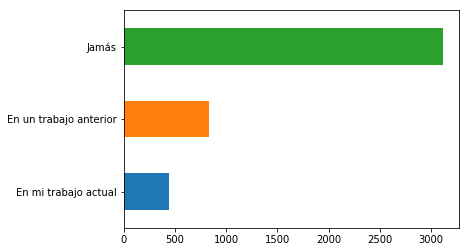

In [34]:
df['¿Sufriste o presenciaste situaciones de violencia laboral?'].value_counts(sort=True, ascending=True).tail(20).plot.barh();

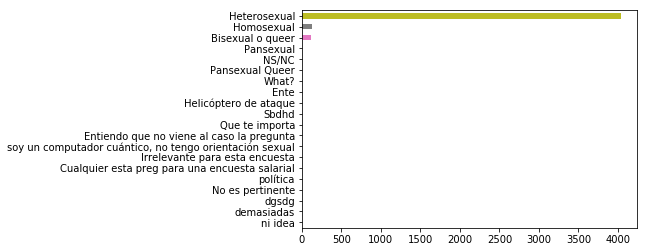

In [35]:
df['Orientación sexual'].value_counts(sort=True, ascending=True).tail(20).plot.barh();

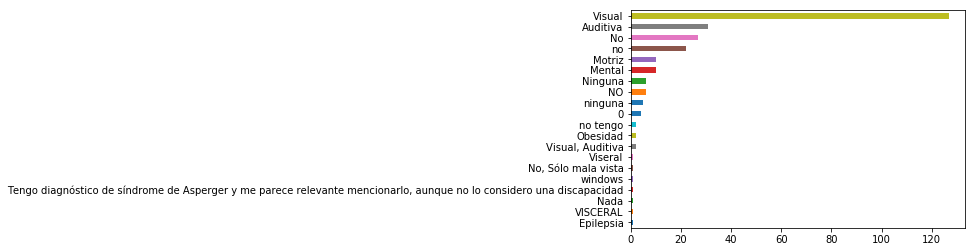

In [36]:
df['¿Tenés algún tipo de discapacidad?'].value_counts(sort=True, ascending=True).tail(20).plot.barh();

'reduced in 0.586207'

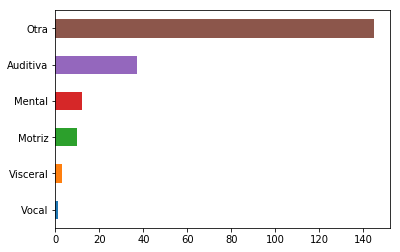

In [37]:
def normalize_dataframe_column(df_in, column_name, regex_assign_map):
  """
  Given a Dataframe (df), a column name that identifies the column to sanitize,
  applies an in-place replacement for each pair regex-value in the map
  """
  df_out = df_in.copy()
  for regex, value in regex_assign_map.items():
    compiled_regex = re.compile(regex, re.I)
    mask = df_in[ column_name ].str.strip().str.match(compiled_regex, na=False)
    df_out.loc[ mask, column_name ] = value
  
  # debug
  total, final = len(df_in[column_name].unique()), len(df_out[column_name].unique())
  display('reduced in {:02f}'.format((total - final) / total))
  return df_out

def normalize_dataframe_column_replace(df_in, column_name, regex_replace_map):
  """
  Given a Dataframe (df), a column name that identifies the column to sanitize,
  applies an in-place replacement for each pair regex-value in the map
  """
  df_out = df_in.copy()
  for regex, pattern in regex_replace_map.items():
    compiled_regex = re.compile(regex, re.I)
    df_out[ column_name ] = df_out[ column_name ].str.strip().str.replace(compiled_regex, pattern)
  
  # debug
  total, final = len(df_in[column_name].unique()), len(df_out[column_name].unique())
  display('reduced in {:02f}'.format((total - final) / total))
  return df_out

df = normalize_dataframe_column(df, '¿Tenés algún tipo de discapacidad?', {
    '^(_|-|no( tengo)?|ningun[oa]|nada|0|)$': None,
    '.*auditiv[oa].*': 'Auditiva',
    '.*visual.*': 'Visual',
    'mental': 'Mental',
    'motriz': 'Motriz',
    'vis?c?eral': 'Visceral',
    '^no, solo mala vista$': None,
    '^no tengo ninguna discapacidad$': None,
    '^tolerancia$': None,
    '^no tengo discapacidad$': None,
    r'^en serio\?$': None,
    r'^idealismo\?$': None,
    r'^si soy lagarto$': None,
    r'^windows$': None,
    r'^social$': None,
    r'^no les interesa$': None,
    r'^edad$': None,
    r'^ninguna \¿Habia que llenar esta respuesta\?$': None,
})
df['¿Tenés algún tipo de discapacidad?'] = df['¿Tenés algún tipo de discapacidad?'].apply(lambda val: val if val in (None, 'Auditiva', 'Mental', 'Motriz', 'Vocal', 'Visceral') or not isinstance(val, str) else 'Otra')
df['¿Tenés algún tipo de discapacidad?'].value_counts(sort=True, ascending=True).tail(20).plot.barh();

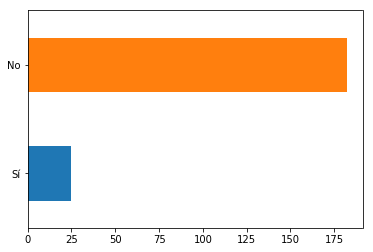

In [40]:
df[~df['¿Tenés algún tipo de discapacidad?'].isna()]['¿Sentís que esto te dificultó el conseguir trabajo?'].value_counts(sort=True, ascending=True).tail(20).plot.barh();

In [39]:
df.columns

Index(['Me identifico', 'Tengo', 'Dónde estás trabajando',
       'Años de experiencia', 'Años en la empresa actual',
       'Años en el puesto actual', '¿Gente a cargo?',
       'Nivel de estudios alcanzado', 'Estado', 'Carrera', 'Universidad',
       'Realizaste cursos de especialización',
       '¿Contribuís a proyectos open source?', '¿Programás como hobbie?',
       'Trabajo de', 'Plataformas', 'Lenguajes de programación',
       'Frameworks, herramientas y librerías', 'Bases de datos',
       'QA / Testing', 'IDEs', '¿Qué SO usás en tu laptop/PC para trabajar?',
       '¿Y en tu celular?', '¿Tenés guardias?', 'Cuánto cobrás por guardia',
       '¿Porcentaje, bruto o neto?', 'Tipo de contrato',
       'Salario mensual BRUTO (en tu moneda local)',
       'Salario mensual NETO (en tu moneda local)',
       '¿Qué tan conforme estás con tu sueldo?',
       'Cómo creés que está tu sueldo con respecto al último semestre',
       'Recibís algún tipo de bono', 'A qué está atado el bono',
